In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#import all of the models I plan on using
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


#import all of the metrics to evaluate each of my models
from sklearn.metrics import accuracy_score, fbeta_score, roc_curve, roc_auc_score, make_scorer
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Import supplementary visualization code visuals.py
import visuals as vs

In [2]:
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [3]:
def plot_roc(name, clf, ytest, xtest):
    roc_auc = roc_auc_score(ytest, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(ytest, clf.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label='ROC curve for %s (area = %0.3f)' % (name, roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    return fpr, tpr

## Data Preprocessing

Let's start out reading in the data file into a Pandas Dataframe. 

In [5]:
data_cumulative = pd.io.stata.read_stata('anes_timeseries_cdf_stata12.dta')

I did some research and found that variable that represents party preference is VCF0301.  I ended up grouping leaning towards the Republican party as being Republican, and did the same for Democrats.  Since this is going to be our target variable, I eliminated the Independents from the data set, as this will be a binary classification problem. I also got rid of people that refused to answer. 

In [6]:
#get rid of independents
data_party_preferred = data_cumulative[data_cumulative.VCF0301 != '4. Independent - Independent']

#get rid of IDK's/NA/Refused to Answer
data_party_preferred = data_party_preferred[data_party_preferred.VCF0301 \
                                            != '0. DK; NA; other; refused to answer; no Pre IW']

Looking at the top of our data, it is clear that the missing data needs to be eliminated since it is abundant.  Most of this was performed manually, where I went though the variable descriptions attached to the dataset and got first got rid of anything not pertinent. 

Rename features so my data is more interpretable and easier to work with.

In [7]:
features = ['VCF0004','VCF0102', 'VCF0104', 'VCF0106', \
            'VCF0110', 'VCF0112', 'VCF0113', 'VCF0114',\
           'VCF0118', 'VCF0127', 'VCF0128',\
           'VCF0143', 'VCF0147', 'VCF0301']
cleaned_data = data_party_preferred[features]
cleaned_data = cleaned_data[(cleaned_data.VCF0004 >= 1952) & (cleaned_data.VCF0004 <= 2012)]
cleaned_data.columns = ['year', 'age_range','gender', 'race_3', 'education_level', 'geo_region', 'south', \
                'hh_income_percentile', 'occupation', 'union_membership', 'religion', 'parents_native_born', \
                'marital_status','party_preference']

#deleted redundant vars with more NAs
#       'VCF0105a' -> race7
#        'VCF0151' -> occupation_feewr

In [8]:
cleaned_data = cleaned_data[cleaned_data.age_range != '0. NA; DK; RF; no Pre IW']
#cleaned_data = cleaned_data[cleaned_data.race_7 != '9. Missing']
cleaned_data = cleaned_data[cleaned_data.race_3 != '0. Missing, pre-1966 data']
cleaned_data= cleaned_data[cleaned_data.race_3 != '9. Missing, DK/REF/NA']
cleaned_data = cleaned_data[cleaned_data.education_level != "0. DK; NA; no Pre IW; short-form 'new' Cross Section"]
cleaned_data = cleaned_data[cleaned_data.hh_income_percentile != '0. DK; NA; refused to answer; no Pre IW']
cleaned_data = cleaned_data[cleaned_data.occupation != '9. DK; NA; no Pre IW']
cleaned_data = cleaned_data[cleaned_data.religion != '0. DK; NA; refused to answer; no Pre IW; no Post IW;']
cleaned_data = cleaned_data[cleaned_data.union_membership != "0. DK; NA; no Pre IW; short-form 'new' Cross"]
cleaned_data = cleaned_data[cleaned_data.parents_native_born != "9. NA; RF; no Pre IW; short-form 'new' Cross Section"]
cleaned_data = cleaned_data[cleaned_data.parents_native_born != "8. DK"]
cleaned_data = cleaned_data[cleaned_data.marital_status != "9.  NA; no Pre IW; unmarried at time of IW (1952 only); short-form 'new' Cross-Section (1992)"]
cleaned_data = cleaned_data[cleaned_data.marital_status != "8. R not married/partnered, refused to say whether never married, divorced, separated or widowed (1992 only); DK"]
#cleaned_data = cleaned_data[cleaned_data.occupation_several != "0. NA; member of armed forces; no occupation and not a"]

#get rid of unsused categories
cleaned_data.party_preference = cleaned_data.party_preference.cat.remove_unused_categories()
cleaned_data.gender = cleaned_data.gender.cat.remove_unused_categories()
cleaned_data.age_range = cleaned_data.age_range.cat.remove_unused_categories()
#cleaned_data.race_7 = cleaned_data.race_7.cat.remove_unused_categories()
cleaned_data.race_3 = cleaned_data.race_3.cat.remove_unused_categories()
cleaned_data.education_level = cleaned_data.education_level.cat.remove_unused_categories()
cleaned_data.hh_income_percentile= cleaned_data.hh_income_percentile.cat.remove_unused_categories()
cleaned_data.occupation = cleaned_data.occupation.cat.remove_unused_categories()
cleaned_data.religion = cleaned_data.religion.cat.remove_unused_categories()
cleaned_data.union_membership = cleaned_data.union_membership.cat.remove_unused_categories()
cleaned_data.parents_native_born = cleaned_data.parents_native_born.cat.remove_unused_categories()
cleaned_data.marital_status = cleaned_data.marital_status.cat.remove_unused_categories()
#cleaned_data.occupation_several = cleaned_data.occupation_several.cat.remove_unused_categories()

#rename categories for cleaner plots
cleaned_data.gender = cleaned_data.gender.cat.rename_categories(['Male', 'Female'])
cleaned_data.party_preference = cleaned_data.party_preference.cat.rename_categories(['Strong Democrat', 'Weak Democrat', 'Leans Democrat', 'Leans Republican', 'Weak Republican', 'Strong Republican'])
cleaned_data.geo_region = cleaned_data.geo_region.cat.rename_categories(['Northeast', 'North Central', 'South', 'West'])
cleaned_data.south = cleaned_data.south.cat.rename_categories(['South', 'Nonsouth'])
cleaned_data.hh_income_percentile = cleaned_data.hh_income_percentile.cat.rename_categories(['0-16 Percentile', '17-33 Percentile', '34-67 Percentile', '68-95 Percentile', '96-100 Percentile'])

In [9]:
sum(cleaned_data.party_preference == 'Strong Democrat') + \
sum(cleaned_data.party_preference == 'Weak Democrat') + \
sum(cleaned_data.party_preference == 'Leans Democrat')

25508

In [10]:
25508./len(cleaned_data.party_preference)

0.5977130002811885

In [11]:
#only include data from the 2004, 2008, and 2012 surveys
historical_data = cleaned_data[(cleaned_data.year >= 1952) & (cleaned_data.year <= 1960)]
historical_data.index = range(historical_data.index.size)

In [12]:
print "Strong Dem: " , sum(historical_data.party_preference == 'Strong Democrat')
print "Weak Dem: " ,sum(historical_data.party_preference == 'Weak Democrat')
print "Leans Dem: " ,sum(historical_data.party_preference == 'Leans Democrat')
print "Strong Rep: " ,sum(historical_data.party_preference == 'Strong Republican')
print "Weak Rep: " ,sum(historical_data.party_preference == 'Weak Republican')
print "Leans Rep: " ,sum(historical_data.party_preference == 'Leans Republican')


Strong Dem:  1451
Weak Dem:  1535
Leans Dem:  479
Strong Rep:  872
Weak Rep:  938
Leans Rep:  441


In [11]:
historical_data['Party'] = ((historical_data.party_preference == "Strong Democrat") | \
(historical_data.party_preference == "Weak Democrat") | \
(historical_data.party_preference == "Leans Democrat")) * 1

In [12]:
float(historical_data.Party.sum())/len(historical_data.Party) #60/40 split- relatively balanced dataset

0.6061931420573828

## Data Exploration Phase

Let's build a color palette for pretty visualizations, representative of the extent to which someone considers themselves a Democrat or Republican, on a 1-6 Scale (Strong Dem, Weak Dem, Leans Dem, Leans Rep, Weak Rep, Strong Rep).

In [13]:
historical_data.shape[0]

5716

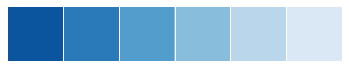

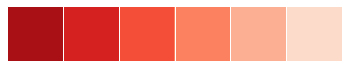

In [14]:
#color palette's I am interested in for my visualizations
sns.palplot(sns.color_palette("Blues_r"))
sns.palplot(sns.color_palette("Reds_r"))

In [15]:
customized_pal = [(0.16696655132641294, 0.48069204152249134, 0.72915032679738567),
 (0.32628988850442142, 0.61862360630526725, 0.80279892349096504),
 (0.73094963475586316, 0.83947712418300646, 0.92132256824298342), 
  (0.9882352941176471, 0.68667435601691651, 0.57788542868127646),
 (0.95700115340253744, 0.30871203383314111, 0.22191464821222606),
(0.83704728950403684, 0.13394848135332565, 0.13079584775086506)]


Now that we have a color palette to differentiate amongnst the training samples, let's explore some of the features in the data set.  

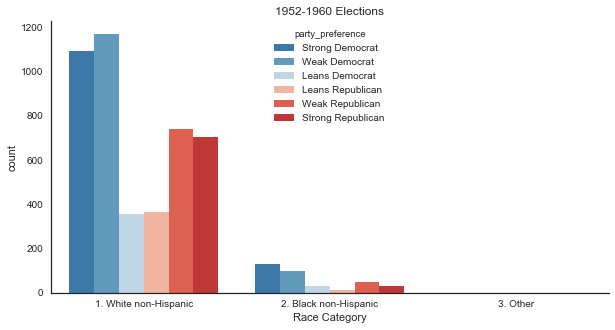

In [16]:
sns.set_style("white")
plt.figure(figsize=(10,5))
sns.countplot(x="race_3", hue="party_preference", data=historical_data,\
              palette=customized_pal)
plt.xlabel('Race Category')
plt.title('1952-1960 Elections')
remove_border()

First thing I notice- there were a lot less black people that were sampled in these elections.  This makes historical sense, considering the Voting Rights Act did not come until 1965. 

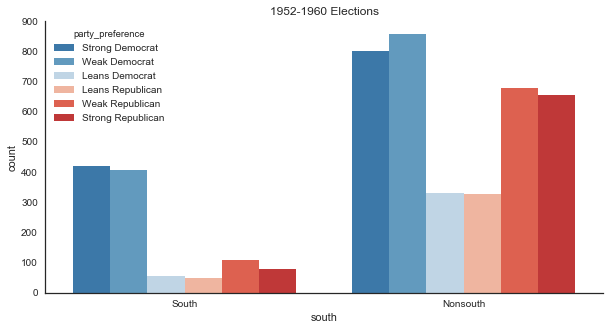

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x="south", hue="party_preference", data=historical_data,\
              palette=customized_pal)
plt.title('1952-1960 Elections')
remove_border()

Interestingly the South as a way higher percentage of comparisons of Democrats compared to modern times.  This most likely derives from the Southern Strategy employed, shifting Demographics in the 1968 election and onwards. 

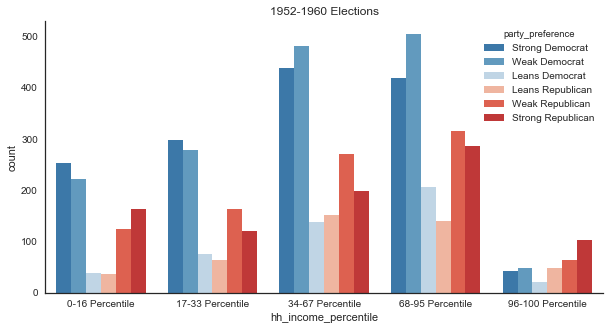

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(x="hh_income_percentile", hue="party_preference", data=historical_data,\
              palette=customized_pal)
plt.title('1952-1960 Elections')
remove_border()

This seems to be very similar to the modern days as well, rich people tend me more Republican.  One thing to note here though- the poorest are more evenly spread compared to modern times. 

In [19]:
sum(historical_data.gender == 'Male')

2700

In [20]:
sum(historical_data.gender == 'Female')

3016

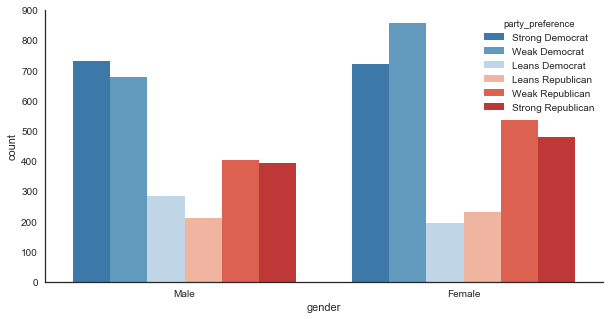

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x="gender", hue="party_preference", data=historical_data,\
              palette=customized_pal)
remove_border()

This is very interesting- there seems to be more Republican females than there are males. There is also roughly an equal amount of males and females (2700 vs 3016). 

In [22]:
#very tedious way of making a point plot...
#was having trouble in seaborn and pandas so I did it all manually instead

male_party = []
male_party.append(sum((historical_data.gender == "Male") & \
    (historical_data.party_preference == "Strong Democrat")))
male_party.append(sum((historical_data.gender == "Male") & \
    (historical_data.party_preference == "Weak Democrat")))
male_party.append(sum((historical_data.gender == "Male") & \
    (historical_data.party_preference == "Leans Democrat")))
male_party.append(sum((historical_data.gender == "Male") & \
    (historical_data.party_preference == "Leans Republican")))
male_party.append(sum((historical_data.gender == "Male") & \
    (historical_data.party_preference == "Weak Republican")))
male_party.append(sum((historical_data.gender == "Male") & \
    (historical_data.party_preference == "Strong Republican")))

female_party = []
female_party.append(sum((historical_data.gender == "Female") & \
    (historical_data.party_preference == "Strong Democrat")))
female_party.append(sum((historical_data.gender == "Female") & \
    (historical_data.party_preference == "Weak Democrat")))
female_party.append(sum((historical_data.gender == "Female") & \
    (historical_data.party_preference == "Leans Democrat")))
female_party.append(sum((historical_data.gender == "Female") & \
    (historical_data.party_preference == "Leans Republican")))
female_party.append(sum((historical_data.gender == "Female") & \
    (historical_data.party_preference == "Weak Republican")))
female_party.append(sum((historical_data.gender == "Female") & \
    (historical_data.party_preference == "Strong Republican")))

count = female_party + male_party

parties = ["Strong Democrat", "Weak Democrat", "Leans Democrat", \
           "Leans Republican", "Weak Republican", "Strong Republican",\
          "Strong Democrat", "Weak Democrat", "Leans Democrat", \
           "Leans Republican", "Weak Republican", "Strong Republican"]
genders = ['Female'] * 6 + ['Male']*6

df = pd.DataFrame({'gender': genders, 'political preference': parties, \
                  'Count': count})

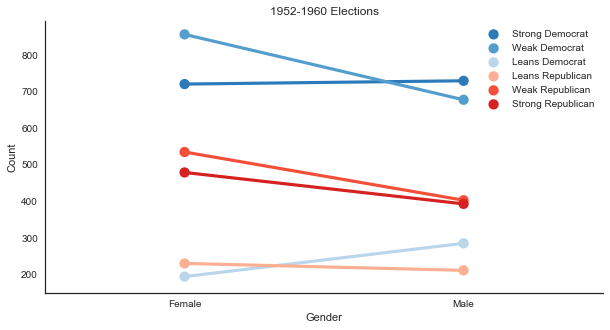

In [23]:
plt.figure(figsize=(10,5))
sns.pointplot(x = "gender", y = "Count", hue = "political preference", \
              data = df, palette=customized_pal)

plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('1952-1960 Elections')
remove_border()

This is much different in comparison to modern times.  Republicans are actually higher in quantity for women as opposed to men. 

## Machine Learning on historical Data

Let's only focus on the historical data now to make some predictions.  I am going to include the data for the 1952-1960 elections.

In [24]:
naive_predictions = np.ones(len(y_test))
print("Final accuracy score on the testing data: {:.4f}"\
      .format(accuracy_score(y_test, naive_predictions)))
print("Final F-score on the testing data: {:.4f}\n"\
          .format(fbeta_score(y_test, naive_predictions, beta = 0.5)))

NameError: name 'y_test' is not defined

In [25]:
historical_data = cleaned_data[(cleaned_data.year >= 1952) & (cleaned_data.year <= 1960)]
historical_data.index = range(historical_data.index.size)
historical_data = historical_data.drop(['year'], axis=1)

Separate the data into its target variable and its features.  

In [26]:
party_historical = historical_data['party_preference']
features_historical = historical_data.drop('party_preference', axis = 1)


In [27]:
#one hot encoding for our features since they are all discrete
features_historical_final =  pd.get_dummies(features_historical)


In [28]:
features_historical_final.head()

,age_range_1. 17 - 24,age_range_2. 25 - 34,age_range_3. 35 - 44,age_range_4. 45 - 54,age_range_5. 55 - 64,age_range_6. 65 - 74,age_range_7. 75 - 99 and over (except 1954),gender_Male,gender_Female,race_3_1. White non-Hispanic,race_3_2. Black non-Hispanic,race_3_3. Other,education_level_1. Grade school or less (0-8 grades),"education_level_2. High school (12 grades or fewer, incl. non-college",education_level_3. Some college (13 grades or more but no degree;,education_level_4. College or advanced degree (no cases 1948),geo_region_Northeast,geo_region_North Central,geo_region_South,geo_region_West,south_South,south_Nonsouth,hh_income_percentile_0-16 Percentile,hh_income_percentile_17-33 Percentile,hh_income_percentile_34-67 Percentile,hh_income_percentile_68-95 Percentile,hh_income_percentile_96-100 Percentile,occupation_1. Employed,"occupation_2. Not employed: laid off, unemployed, on strike,",occupation_3. Retired,occupation_4. Homemaker (since 1972: not working 20 or more hrs/wk;,occupation_5. Student (since 1972: not working 20 or more hrs/wk;,"union_membership_1. Yes, someone (1948: head) in household belongs to a","union_membership_2. No, no one in household belongs to a labor union",religion_1. Protestant,religion_2. Catholic [Roman Catholic],religion_3. Jewish,religion_4. Other and none (also includes DK preference),parents_native_born_1. Yes,parents_native_born_5. No,marital_status_1. Married,marital_status_2. Never married,marital_status_3. Divorced,marital_status_4. Separated,marital_status_5. Widowed,"marital_status_7. Partners; not married (VOLUNTEERED [exc.1986,2012])"
0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0


We need to convert our party preferential categories into a binary category.  This is done by encoding "Democrat" as 1 and "Republican" as 0. 

In [29]:
convert_to_binary = ((party_historical == "Strong Democrat") | \
(party_historical == "Weak Democrat") | \
(party_historical == "Leans Democrat")) * 1

In [30]:
combined_party_encoding= pd.concat([party_historical, convert_to_binary], axis=1)
combined_party_encoding.columns = ['Category', 'Binary']
party_historical_final = combined_party_encoding['Binary']

In [31]:
import warnings
warnings.filterwarnings('ignore')

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_historical_final, 
                                                    party_historical_final, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4572 samples.
Testing set has 1144 samples.


Let's start by assessing the score og a logisitic regression classifier, one of the more basic algorithms often used for binary classification problems. Since there is some imbalance in my classes (60-40 Dem-Rep split), I thought it would be wise to also generate a Receiver Operating Characteristic in order to better visualize the predictive capabilities of my classifier. 

Accuracy: 0.712


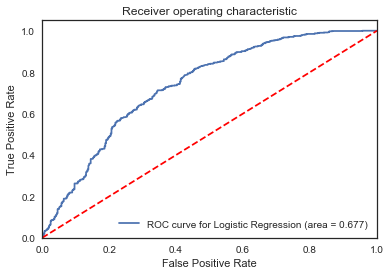

In [32]:
from sklearn.linear_model import LogisticRegression

logreg_1 = LogisticRegression()
logreg_1.fit(X_train, y_train)
predictions = logreg_1.predict(X_test)
score = logreg_1.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_logreg_1, tpr_logreg_1 = plot_roc("Logistic Regression", logreg_1, y_test, X_test)


Not a bad testing accuracy for a baseline classifier, but I think I can squeeze a little more out of it.  My testing set is ~6000 samples currently, but this could be higher if reduce the redundant inputs in my feature space.  I will get rid of the race input with seven categories and one of the occupation classes. 

My reasoning is this: I filter out all NA values, which will reduce my data set size with each feature I add. 

Accuracy: 0.712


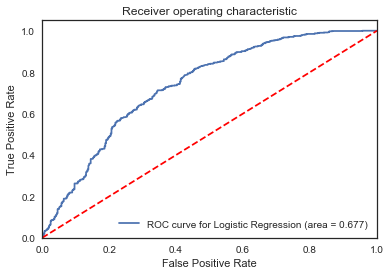

In [33]:
logreg_2 = LogisticRegression()
logreg_2.fit(X_train, y_train)
predictions = logreg_2.predict(X_test)
score = logreg_2.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_logreg_2, tpr_logreg_2 = plot_roc("Logistic Regression", logreg_2, y_test, X_test)


Cleaning up the feature set was certainly helpful.  We went from a 69.2 accuracy to 72.6 and our ROC curve area increased from 0.67 to 0.70. 

Now, before I attempt different algorithms to squeeze the most performance out of my model as possible, I am going to try and build additional features from my data set to see if that can improve my model a little bit.  




## Feature Importance

Now that we have stripped out dataset to be more digestible, we can start investigating into the feature importance.  I will first do this using the recursive method for logistic regression, in which the most important feature is found, then dropped for the next iteration of the algorithm, continuously until the most prevalent features are accounted for.  

In [34]:
from sklearn.feature_selection import RFE
model = LogisticRegression()
# Let's find the top attribute
rfe = RFE(model, 1)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False]
[17 21 20 43 30 34 11 26 27 38  7 45 16 15 44 25  5 42 13 14  2 12 24 23 31
 32  1 40 10 28 19 29  6 33  3  9  4 22 41 35 36 37  8 18 39 46]


In [35]:
features_with_rank = []
for i in range(1, len(features_historical_final.columns) + 1):
    features_with_rank.append(str(rfe.ranking_[i-1]) + '. ' + features_historical_final.columns[i -1])

for i in features_with_rank:
    print i

17. age_range_1. 17 - 24
21. age_range_2. 25 - 34
20. age_range_3. 35 - 44
43. age_range_4. 45 - 54
30. age_range_5. 55 - 64
34. age_range_6. 65 - 74
11. age_range_7. 75 - 99 and over (except 1954)
26. gender_Male
27. gender_Female
38. race_3_1. White non-Hispanic
7. race_3_2. Black non-Hispanic
45. race_3_3. Other
16. education_level_1. Grade school or less (0-8 grades)
15. education_level_2. High school (12 grades or fewer, incl. non-college
44. education_level_3. Some college (13 grades or more but no degree;
25. education_level_4. College or advanced degree (no cases 1948)
5. geo_region_Northeast
42. geo_region_North Central
13. geo_region_South
14. geo_region_West
2. south_South
12. south_Nonsouth
24. hh_income_percentile_0-16 Percentile
23. hh_income_percentile_17-33 Percentile
31. hh_income_percentile_34-67 Percentile
32. hh_income_percentile_68-95 Percentile
1. hh_income_percentile_96-100 Percentile
40. occupation_1. Employed
10. occupation_2. Not employed: laid off, unemployed

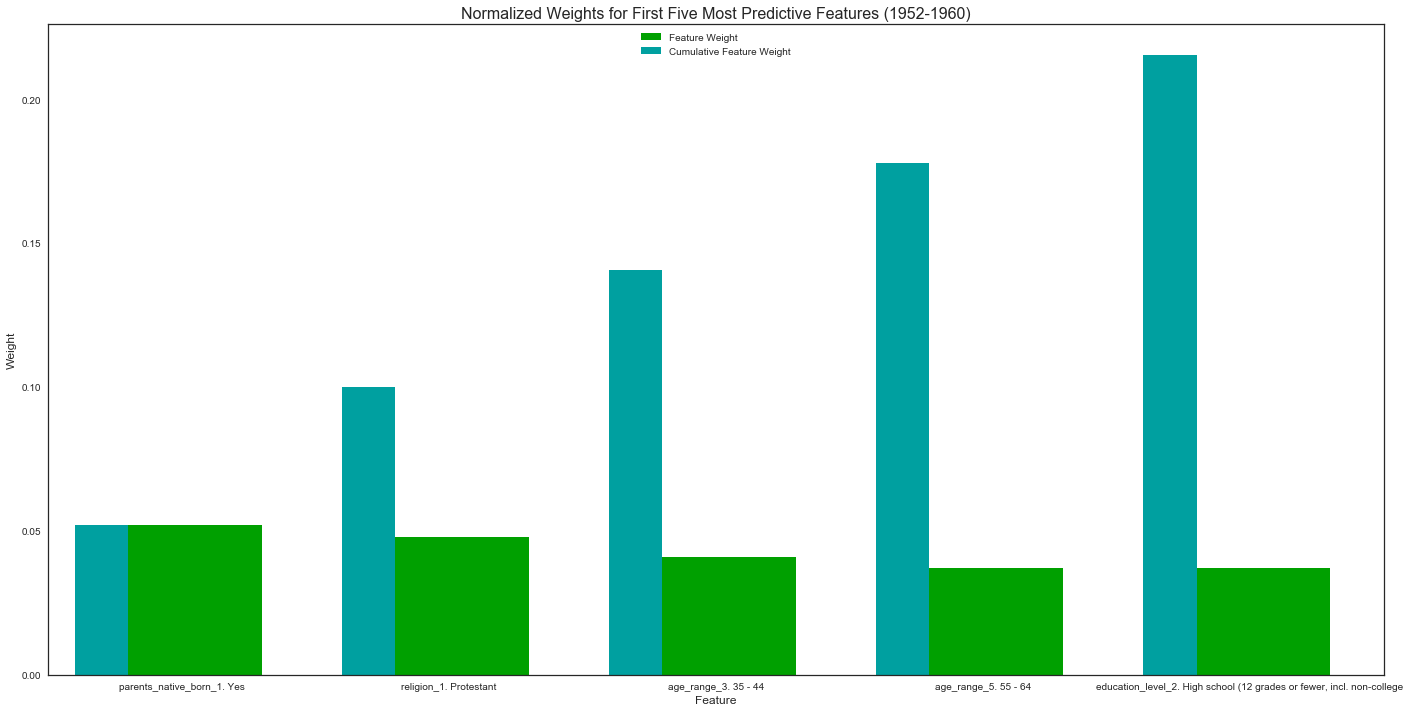

In [45]:
# Import a supervised learning model that has 'feature_importances_'

from sklearn.ensemble import RandomForestClassifier
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]
fig = plt.figure(figsize = (20,10))
plt.title("Normalized Weights for First Five Most Predictive Features (1952-1960)", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)
    
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()  
#vs.feature_plot(importances, X_train, y_train)

## Model Comparison

Let's look into the performance of several models to see which ones we should further investigate. We will first do a comparison based on the accuracies of each of the model outputs.  

Accuracy: 0.678


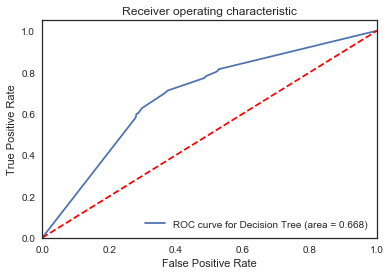

In [37]:

d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
score = d_tree.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_d_tree, tpr_d_tree = plot_roc("Decision Tree", d_tree, y_test, X_test)


Accuracy: 0.687


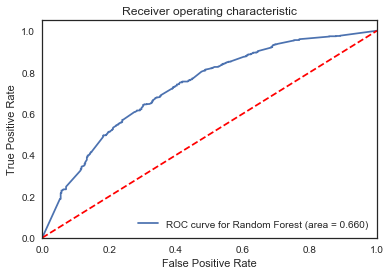

In [38]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
predictions = RF.predict(X_test)
score = RF.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_RF, tpr_RF = plot_roc("Random Forest", RF, y_test, X_test)


Accuracy: 0.716


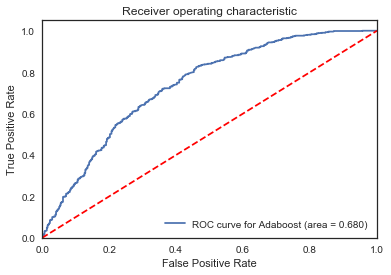

In [39]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
predictions = adaboost.predict(X_test)
score = adaboost.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_ada, tpr_ada = plot_roc("Adaboost", adaboost, y_test, X_test)


In [40]:
from xgboost import XGBClassifier

clf = AdaBoostClassifier()
clf.fit(X_train.values, y_train.values)
predictions = clf.predict(X_test.values)
score = clf.score(X_test.values, y_test.values)
print ("Accuracy: %.3f" %(score))
print("Final accuracy score on the testing data: {:.4f}"\
      .format(accuracy_score(y_test, predictions)))
print("Final F-score on the testing data: {:.4f}"\
      .format(fbeta_score(y_test, predictions, beta = 0.5)))

Accuracy: 0.716
Final accuracy score on the testing data: 0.7159
Final F-score on the testing data: 0.7580


Log Reg: Accuracy: 0.685482 Std: (0.017915)
CART: Accuracy: 0.631680 Std: (0.016773)
Random Forest: Accuracy: 0.665352 Std: (0.017607)
AdaBoost: Accuracy: 0.681548 Std: (0.019307)
SVM: Accuracy: 0.692915 Std: (0.015968)


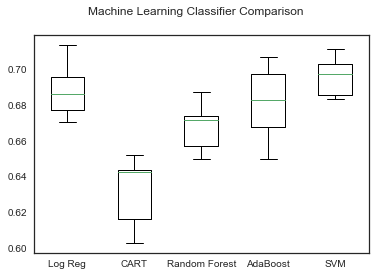

In [41]:
# prepare models for comparative analysis
models = []
models.append(('Log Reg', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('SVM', SVC()))

# evaluate each model in turn
seed = 0
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    output = "%s: Accuracy: %f Std: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning Classifier Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Let's do the same thing as above, except this time let's look into the F1 Score's since our dataset has some class imbalance within it. 

Log Reg: F1 Score: 0.757902 Std: (0.013104)
CART: F1 Score: 0.684762 Std: (0.015477)
Random Forest: F1 Score: 0.729958 Std: (0.016663)
AdaBoost: F1 Score: 0.754175 Std: (0.014772)
SVM: F1 Score: 0.766712 Std: (0.012802)


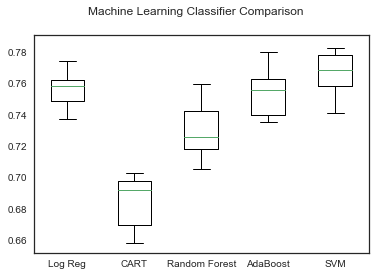

In [42]:
# prepare models for comparative analysis
models = []
models.append(('Log Reg', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('SVM', SVC()))

# evaluate each model in turn
seed = 0
results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    output = "%s: F1 Score: %f Std: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning Classifier Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Hyperparameter Tuning 

It looks like the highest performance models from both an F score and accuracy standpoint are logistic regression, AdaBoost, and SVM.  Let's do some optimizations to see if we can improve our model even more. 

In [43]:
#the four models I want to tune
logistic = LogisticRegression()
adaboost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
svm = SVC(kernel = 'rbf')

models = [logistic, adaboost, grad_boost, svm]
best_estimators = []
for model in models:
    if model == logistic:
        hyperparameters = dict(C=np.logspace(0,4,10), penalty=['l1', 'l2'])
    elif model == adaboost:
        hyperparameters = {'n_estimators':range(10,101,10)}
    elif model == grad_boost:
        hyperparameters = {'n_estimators':range(10,81,10),
                           'max_depth':range(1,10,2)}
    else: #model is SVM
        hyperparameters = {'C': [ 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1]}
        
    grid = GridSearchCV(model, hyperparameters, cv=5, verbose=0)  
    grid_fit = grid.fit(X_train, y_train)
    best_estimators.append(grid_fit.best_estimator_)
    
        
print best_estimators    

[LogisticRegression(C=2.7825594022071245, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=40, random_state=None), GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=20, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False), SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, rand

In [44]:
logistic = LogisticRegression(penalty = 'l2', C = 2.7825594)
adaboost = AdaBoostClassifier(n_estimators= 40)
grad_boost = GradientBoostingClassifier(n_estimators = 50, max_depth = 5)
svm = SVC(kernel = 'rbf', C = 1, gamma = 0.1)


optimized_models = [logistic, adaboost, grad_boost, svm]

for model in optimized_models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    print"Model: %s\n" %str(model)
    print("Final accuracy score on the testing data: {:.4f}"\
      .format(accuracy_score(y_test, predictions)))
    print("Final F-score on the testing data: {:.4f}\n"\
          .format(fbeta_score(y_test, predictions, beta = 0.5)))
    

Model: LogisticRegression(C=2.7825594, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Final accuracy score on the testing data: 0.7115
Final F-score on the testing data: 0.7555

Model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=40, random_state=None)

Final accuracy score on the testing data: 0.7133
Final F-score on the testing data: 0.7560

Model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=None,
              subsample=